### Earthquake Modeling

In [1]:
%matplotlib inline
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb
import shap

warnings.filterwarnings("ignore")


/Users/maldonam/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### 1. Load the cleaned data

In [2]:
earthquakes = pd.read_csv('master_df.csv')
print(earthquakes.shape)

earthquakes_reduced = pd.read_csv('master_df_reduced.csv')
print(earthquakes_reduced.shape)

earthquakes_reg_pop = pd.read_csv('master_df_regional_pop.csv')
print(earthquakes_reg_pop.shape)


(1030, 44)
(1030, 11)
(1030, 49)


#### 2. Explore Dataset and Missing Values

In [3]:
earthquakes_reg_pop.head()

,Unnamed: 0,Year,Mo,Dy,Hr,Mn,Sec,Tsu,Vol,Country,...,Total Houses Damaged Description,Total Houses Damaged Description.1,Region,Average Income,p0p50_share,Population density national,preperation_zone,pop_with_water,pop_without_water,pop_total
0,0,2000,1,11,23.0,43.0,56.4,NaN,NaN,CHINA,...,4.0,4.0,LIAONING PROVINCE,4836.4401,0.1737,134.647500,164.9,196.047281,248.925429,2.089903e+07
1,1,2000,1,14,23.0,37.0,7.8,NaN,NaN,CHINA,...,NaN,NaN,YAOAN COUNTY,4836.4401,0.1737,134.647500,356.1,75.744613,76.155580,3.829049e+07
2,2,2000,6,7,21.0,46.0,55.9,NaN,NaN,CHINA,...,NaN,NaN,LIUKU; MYANMAR,4836.4401,0.1737,134.647500,572.6,36.681915,38.318019,4.788112e+07
3,3,2000,8,21,13.0,25.0,44.5,NaN,NaN,CHINA,...,NaN,NaN,WUDING,4836.4401,0.1737,134.647500,70.2,67.648044,67.648044,1.307028e+06
4,4,2000,2,2,22.0,58.0,1.5,NaN,NaN,IRAN,...,3.0,3.0,KASHMAR,13549.8134,0.1232,40.397152,212.7,30.027525,30.027525,5.372795e+06


In [4]:
earthquakes_reg_pop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 49 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Unnamed: 0                          1030 non-null   int64  
 1   Year                                1030 non-null   int64  
 2   Mo                                  1030 non-null   int64  
 3   Dy                                  1030 non-null   int64  
 4   Hr                                  1030 non-null   float64
 5   Mn                                  1030 non-null   float64
 6   Sec                                 1024 non-null   float64
 7   Tsu                                 168 non-null    float64
 8   Vol                                 7 non-null      float64
 9   Country                             1030 non-null   object 
 10  Location Name                       1030 non-null   object 
 11  Latitude                            1030 no

Counting Missing values on the dataset

In [5]:
df = earthquakes_reg_pop.copy()
# number and percentage of missing values according to columns
{col: [df[col].isnull().sum(), f'% {np.round(np.mean(df[col].isnull()*100), 3)}'
      ] for col in df.columns if df[col].isnull().any()}

{'Sec': [6, '% 0.583'],
 'Tsu': [862, '% 83.689'],
 'Vol': [1023, '% 99.32'],
 'Focal Depth (km)': [11, '% 1.068'],
 'Mag': [3, '% 0.291'],
 'MMI Int': [720, '% 69.903'],
 'Deaths': [576, '% 55.922'],
 'Death Description': [574, '% 55.728'],
 'Missing': [1015, '% 98.544'],
 'Missing Description': [1016, '% 98.641'],
 'Injuries': [432, '% 41.942'],
 'Injuries Description': [390, '% 37.864'],
 'Damage ($Mil)': [878, '% 85.243'],
 'Damage Description': [150, '% 14.563'],
 'Houses Destroyed': [734, '% 71.262'],
 'Houses Destroyed Description': [603, '% 58.544'],
 'Houses Damaged': [710, '% 68.932'],
 'Houses Damaged Description': [509, '% 49.417'],
 'Total Deaths': [568, '% 55.146'],
 'Total Death Description': [568, '% 55.146'],
 'Total Missing': [1015, '% 98.544'],
 'Total Missing Description': [1013, '% 98.35'],
 'Total Injuries': [426, '% 41.359'],
 'Total Injuries Description': [384, '% 37.282'],
 'Total Damage ($Mil)': [873, '% 84.757'],
 'Total Damage Description': [148, '% 14.369']

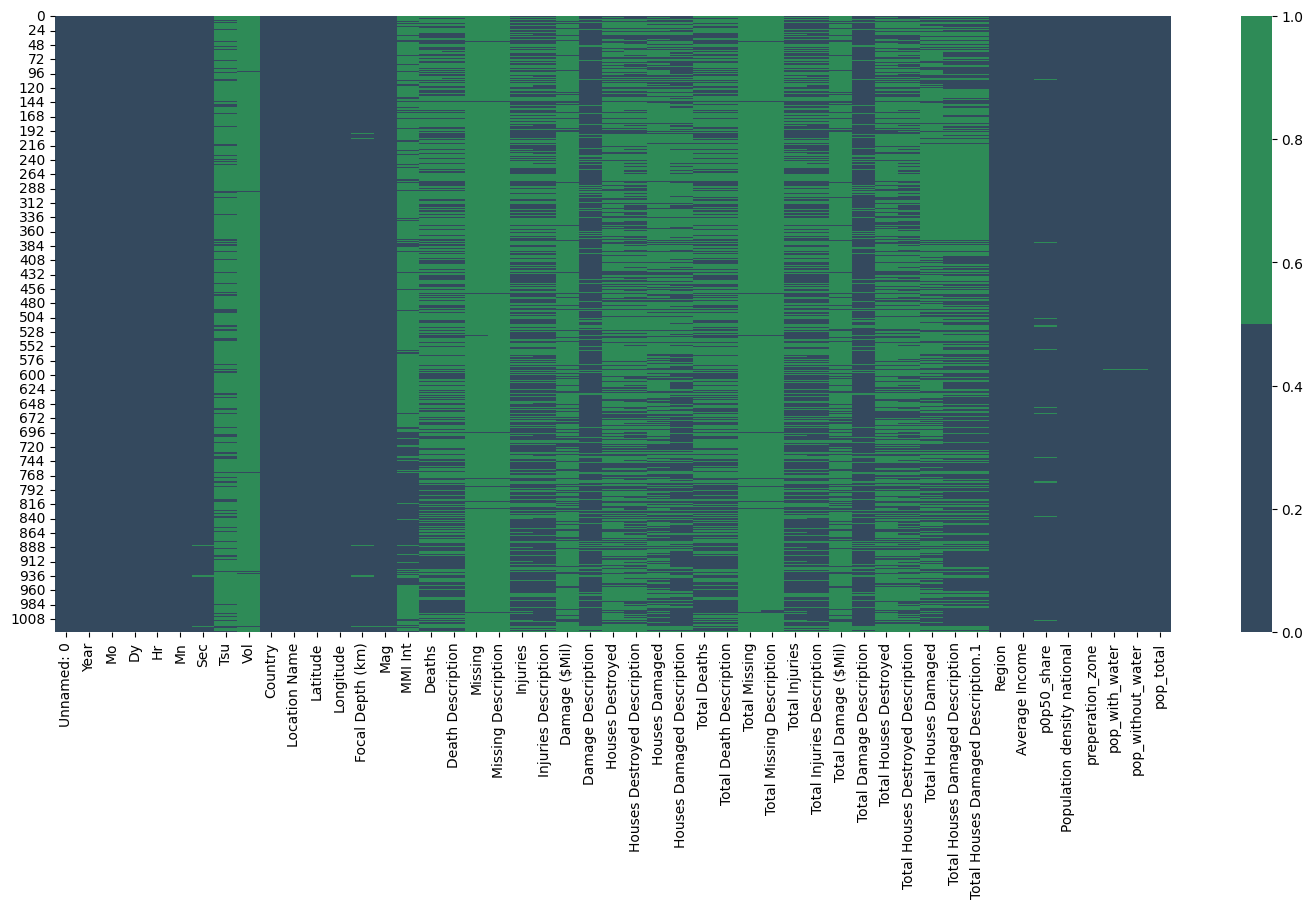

In [6]:
plt.figure(figsize=(18,8))
colours = ['#34495E', 'seagreen'] 
mis =sns.heatmap(df.isnull(), cmap=sns.color_palette(colours))
mis.figure.savefig('mis_heatmap.png')


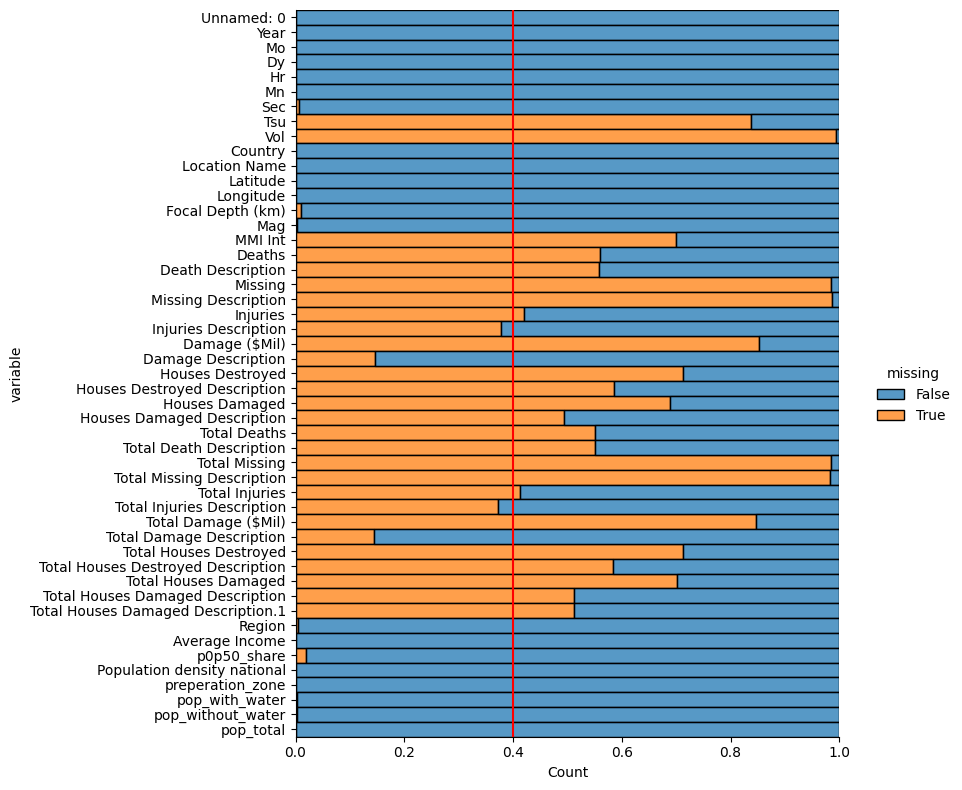

In [7]:
mis2 = sns.displot(
    data=df.isnull().melt(value_name='missing'),
    y='variable',
    hue='missing',
    multiple='fill',
    height=8,
    aspect=1.1
)
mis2.savefig('mis_barplot.png')
plt.axvline(0.4, color='r')


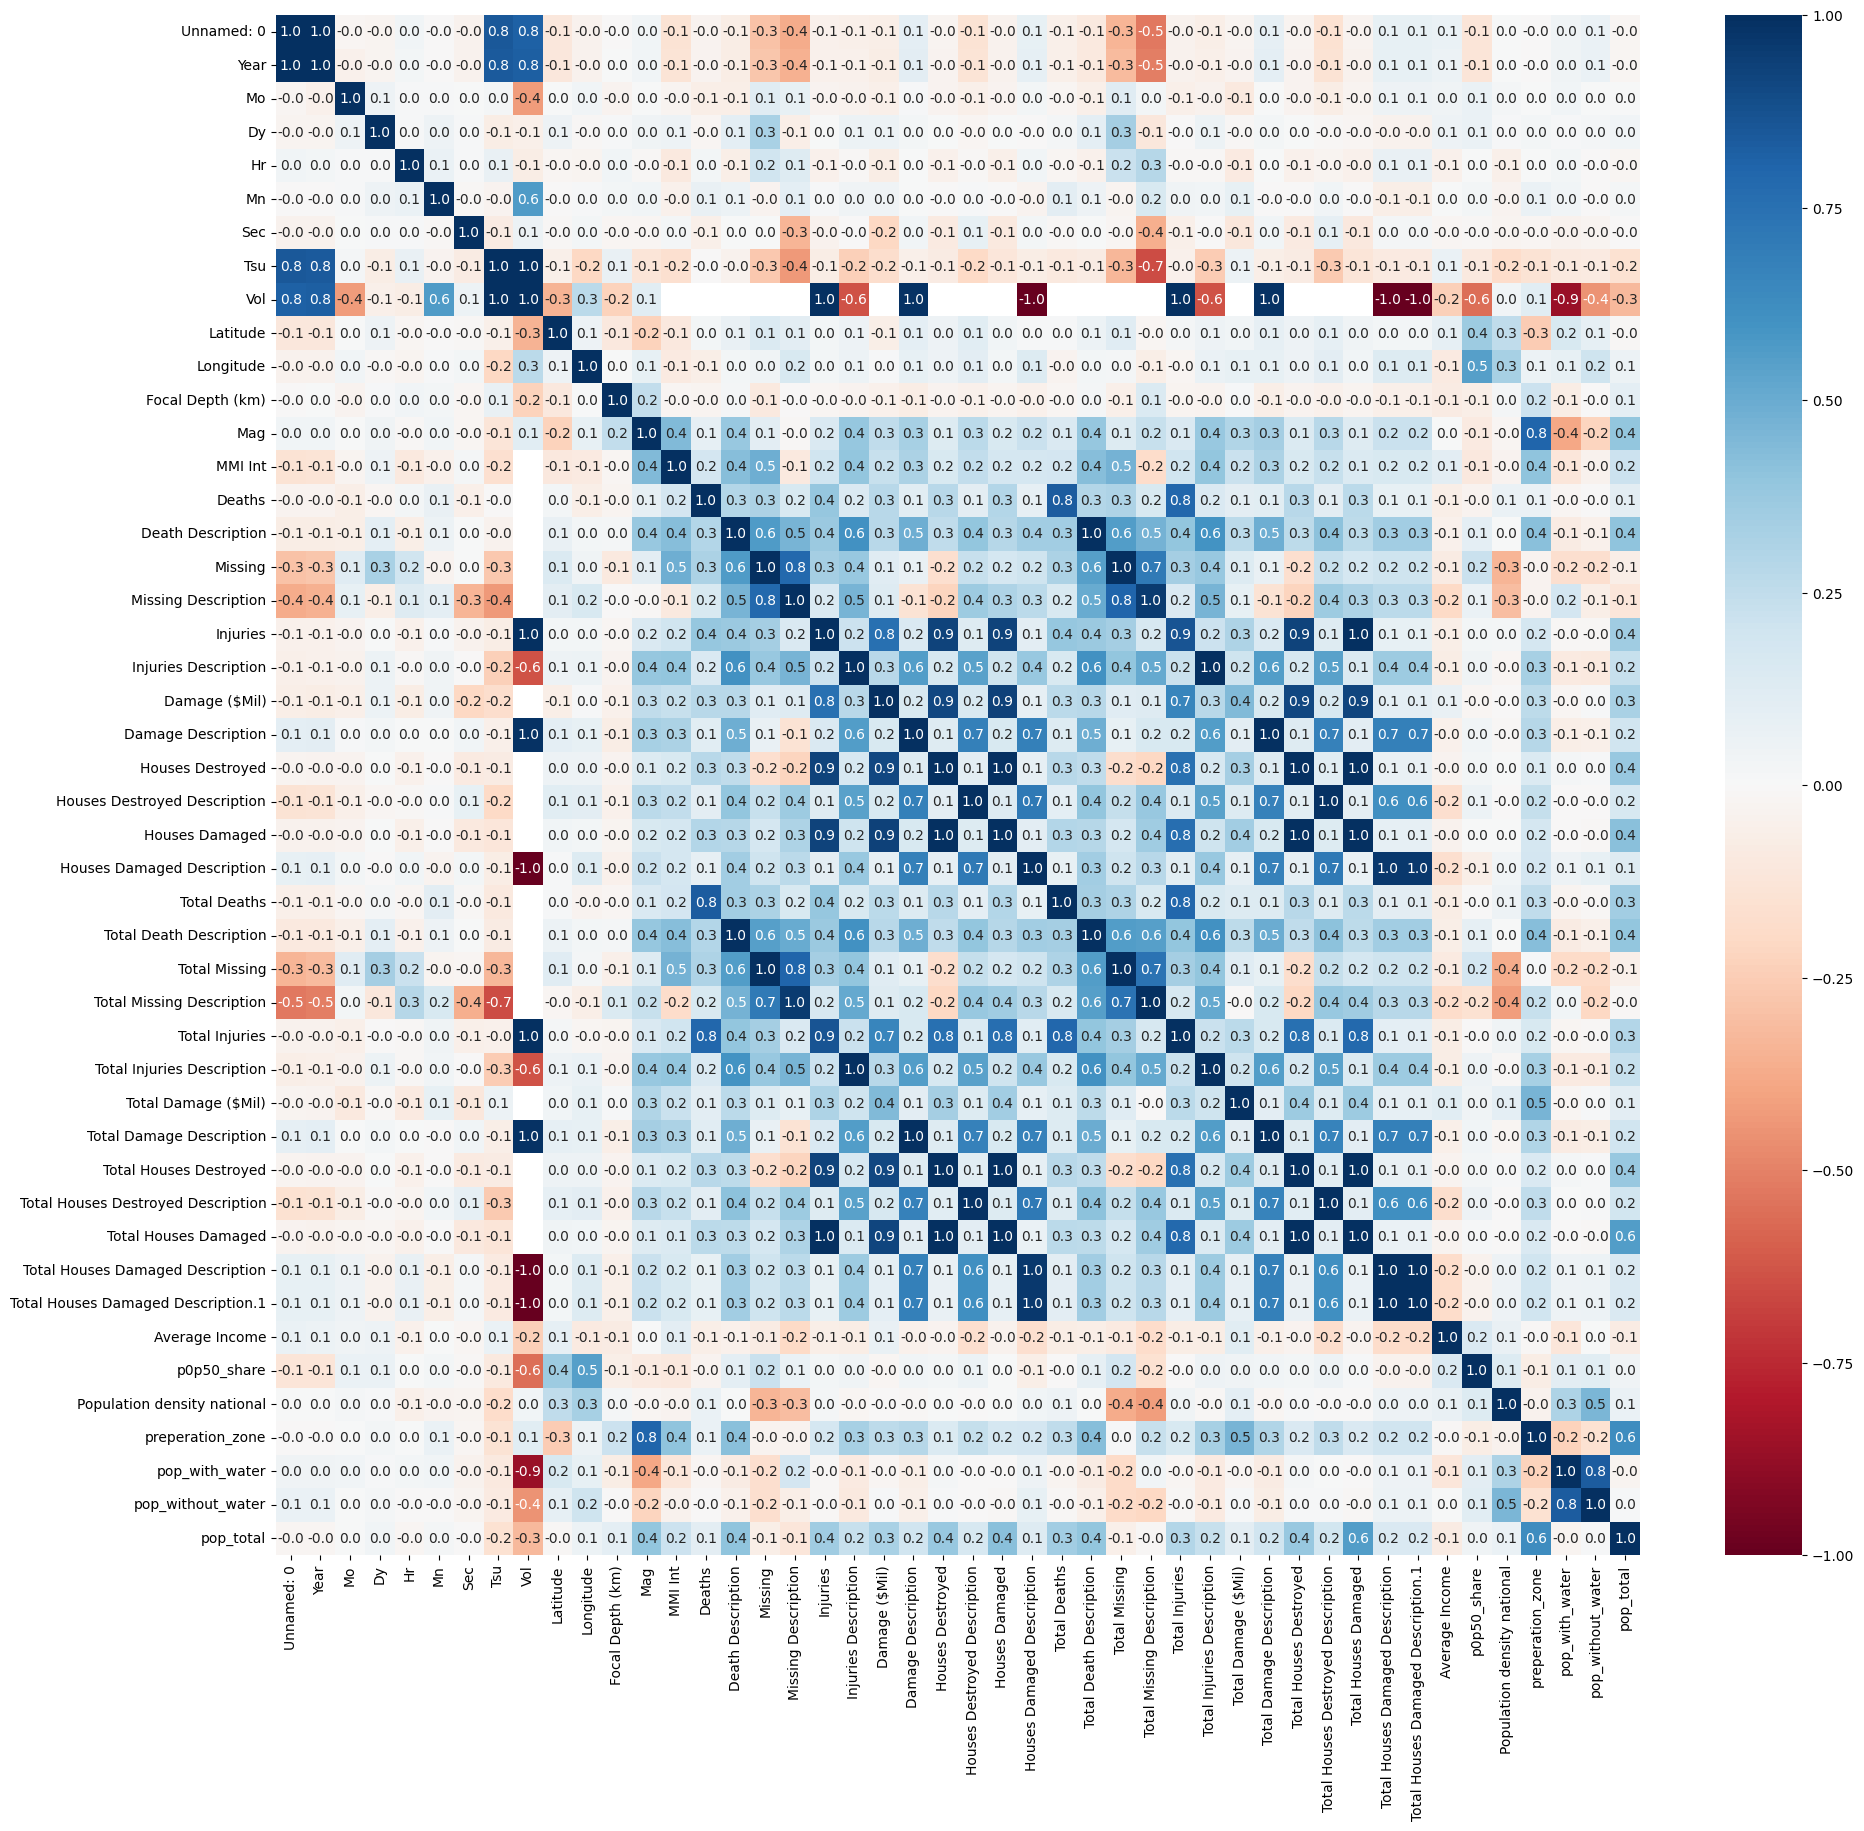

In [8]:
num_df = df.select_dtypes(include='number')
cat_df = df.select_dtypes(exclude='number')


corr_matrix = num_df.corr()

fig, ax = plt.subplots()
fig.set_size_inches(22, 20)
corr = sns.heatmap(corr_matrix, annot=True, fmt=".1f", cmap="RdBu", center=0, ax=ax)  

corr.figure.savefig('corr_heatmap.png')

#### 3.Modeling Regression

a) HistGradientBoostingRegressor (LightGBM Boosted trees)

b) CatBoost boosted trees

c) Random Forest

d) Extremely Randomized Trees

e) k- Nearest Neighbours

3.1 Split numerical and categorical variables

We define "Total Damage Description" as the Target Variable that ranges between 1 to 4 and that is associate to the degree of damage of each Earthquake. As it normally can be treated as a Target Categorical variable, we prefer to use it as a discrete continuos variable due to the fact that there is a lot of missing values in the datasets. 

3.2. Impute Numerical values with KNN Imputer method

In [9]:

# Create an instance of KNNImputer
imputer = KNNImputer(n_neighbors=5)

#assuming that Total Damage Description is the target variable with meaning of the values between 0 and 4

X = num_df.drop('Total Damage Description', axis=1)
y = num_df['Total Damage Description']

# Use KNNImputer to fill NaN values in 'y'
y = imputer.fit_transform(y.values.reshape(-1,1))

# Now 'y' is a 2D array, reshape it to 1D
y = y.reshape(-1)

# Split the data
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


3.3 Train and Test Ensambles and Tree-based Regressor Models

a) HistGradientBoostingRegressor (LightGBM Boosted trees)

In [10]:
# Train the model
est = HistGradientBoostingRegressor().fit(x_train, y_train)

predictions = est.predict(x_test)

print("R2:",est.score(x_test, y_test))
print("MSE:",mean_squared_error(y_test, predictions))


R2: 0.9777240615375286
MSE: 0.02231729123077595


b) CatBoost boosted trees

In [11]:

# Train the model
est_catboost = CatBoostRegressor().fit(x_train, y_train)

predictions_catboost = est_catboost.predict(x_test)

print("R2:", est_catboost.score(x_test, y_test))
print("MSE:", mean_squared_error(y_test, predictions_catboost))


Learning rate set to 0.038612
0:	learn: 0.9876350	total: 57.7ms	remaining: 57.7s
1:	learn: 0.9627075	total: 58.5ms	remaining: 29.2s
2:	learn: 0.9397252	total: 59.1ms	remaining: 19.6s
3:	learn: 0.9173234	total: 59.8ms	remaining: 14.9s
4:	learn: 0.8961739	total: 60.4ms	remaining: 12s
5:	learn: 0.8750262	total: 61ms	remaining: 10.1s
6:	learn: 0.8515751	total: 62ms	remaining: 8.79s
7:	learn: 0.8296358	total: 62.7ms	remaining: 7.77s
8:	learn: 0.8109649	total: 63.5ms	remaining: 6.99s
9:	learn: 0.7896627	total: 64.4ms	remaining: 6.38s
10:	learn: 0.7692353	total: 65ms	remaining: 5.85s
11:	learn: 0.7519613	total: 65.6ms	remaining: 5.4s
12:	learn: 0.7276693	total: 66.2ms	remaining: 5.03s
13:	learn: 0.7120107	total: 66.9ms	remaining: 4.71s
14:	learn: 0.6960859	total: 67.6ms	remaining: 4.44s
15:	learn: 0.6751266	total: 68.3ms	remaining: 4.2s
16:	learn: 0.6618588	total: 68.9ms	remaining: 3.98s
17:	learn: 0.6399130	total: 69.7ms	remaining: 3.8s
18:	learn: 0.6230177	total: 70.4ms	remaining: 3.64s
19:

c) Random Forest

In [12]:

# Train the model
est_randomforest = RandomForestRegressor().fit(x_train, y_train)

predictions_randomforest = est_randomforest.predict(x_test)

print("R2:", est_randomforest.score(x_test, y_test))
print("MSE:", mean_squared_error(y_test, predictions_randomforest))


R2: 0.9802929146938404
MSE: 0.01974366928819902


d) Extremely Randomized Trees

In [13]:
# Create an instance of KNNImputer
imputer = KNNImputer(n_neighbors=5)

#assuming that Total Damage Description is the target variable with meaning of the values between 0 and 4

X = num_df.drop('Total Damage Description', axis=1)
y = num_df['Total Damage Description']

# Use KNNImputer to fill NaN values in 'y'
y = imputer.fit_transform(y.values.reshape(-1,1))
X = imputer.fit_transform(X)

# Now 'y' is a 2D array, reshape it to 1D
y = y.reshape(-1)

# Split the data
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Train the model
est_extratrees = ExtraTreesRegressor().fit(x_train, y_train)

predictions_extratrees = est_extratrees.predict(x_test)

print("R2:", est_extratrees.score(x_test, y_test))
print("MSE:", mean_squared_error(y_test, predictions_extratrees))

R2: 0.9641228391613919
MSE: 0.03594376274281443


e) K- Nearest Neigbours

In [14]:
# Train the model
est_knn = KNeighborsRegressor().fit(x_train, y_train)

predictions_knn = est_knn.predict(x_test)

print("R2:", est_knn.score(x_test, y_test))
print("MSE:", mean_squared_error(y_test, predictions_knn))


R2: 0.023959381658442025
MSE: 0.9778525277079844


3.4 Model Comparision

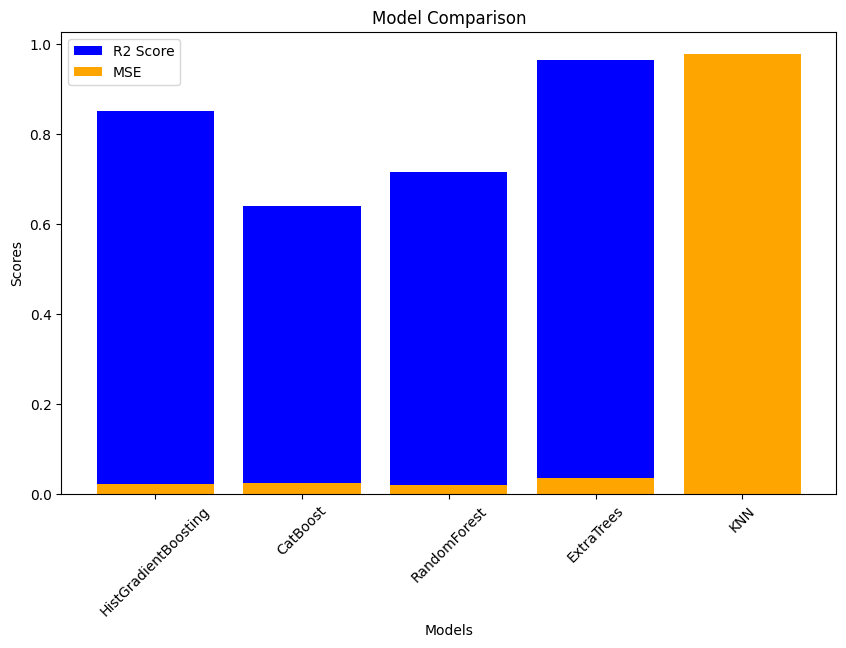

In [15]:
# Define the model names and corresponding scores
model_names = ['HistGradientBoosting', 'CatBoost', 'RandomForest', 'ExtraTrees', 'KNN']
r2_scores = [est.score(x_test, y_test), est_catboost.score(x_test, y_test), est_randomforest.score(x_test, y_test), est_extratrees.score(x_test, y_test), est_knn.score(x_test, y_test)]
mse_values = [mean_squared_error(y_test, predictions), mean_squared_error(y_test, predictions_catboost), mean_squared_error(y_test, predictions_randomforest), mean_squared_error(y_test, predictions_extratrees), mean_squared_error(y_test, predictions_knn)]

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(model_names, r2_scores, color='blue', label='R2 Score')
plt.bar(model_names, mse_values, color='orange', label='MSE')
plt.xlabel('Models')
plt.ylabel('Scores')
plt.title('Model Comparison')
plt.legend()
plt.xticks(rotation=45)

plt.show()

#### 4. Logistic Regression

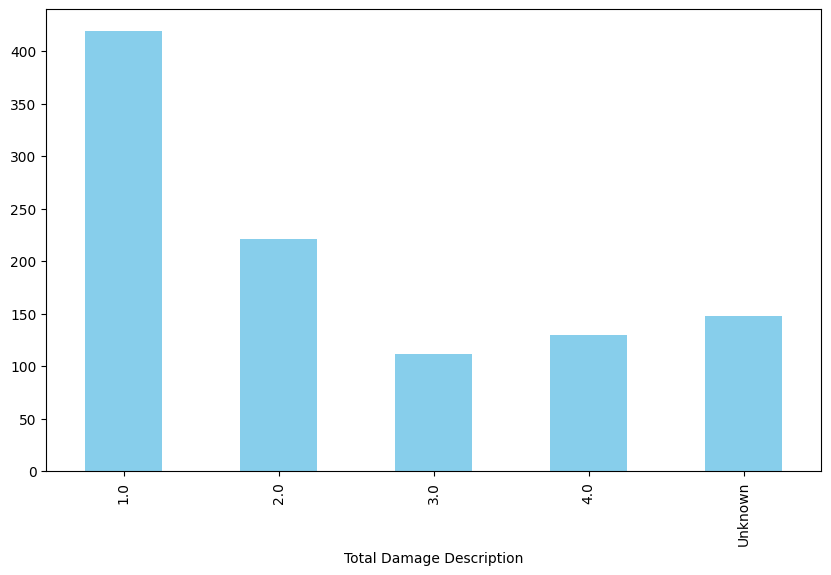

In [16]:
import matplotlib.pyplot as plt

# Create category Unknown for missing in Total Damage Description
num_df['Total Damage Description'].fillna('Unknown', inplace=True)
categories = num_df.groupby('Total Damage Description').size().plot(kind='bar', figsize=(10, 6), color='skyblue')

# Save the figure
plt.savefig('Target Classes.png')


In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

y = num_df['Total Damage Description'].astype('category').cat.codes
X = num_df.drop('Total Damage Description', axis=1)

# Create an instance of KNNImputer
imputer = KNNImputer(n_neighbors=5)
X = imputer.fit_transform(X)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

logit = LogisticRegression(penalty="l2", solver='lbfgs', C=1e24, multi_class='multinomial')
logit.fit(x_train, y_train)

print('  intercept', logit.intercept_)
print('  coefficients', logit.coef_)
print('classes', logit.classes_)
print()

probs = logit.predict_proba(X)

results = pd.DataFrame({
    'actual': y, 'predicted': logit.predict(X),
    'P(0)': [p[0] for p in probs],
    'P(1)': [p[1] for p in probs],
    'P(2)': [p[2] for p in probs],
    'P(3)': [p[3] for p in probs],
    'P(4)': [p[4] for p in probs],
})
print(results.head())
print()

test_probs = logit.predict_proba(x_test)
test_results = pd.DataFrame({
    'actual': y_test, 'predicted': logit.predict(x_test),
    'P(0)': [p[0] for p in test_probs],
    'P(1)': [p[1] for p in test_probs],
    'P(2)': [p[2] for p in test_probs],
    'P(3)': [p[3] for p in test_probs],
    'P(4)': [p[4] for p in test_probs],
})
print(test_results.head())


  intercept [ 1.70158566e-09  1.32402062e-10 -5.46364557e-10 -8.27044885e-10
 -4.60578278e-10]
  coefficients [[ 7.33618062e-07  3.41716073e-06  1.17446465e-08  2.84005514e-08
   1.85973887e-08  5.36381692e-08  4.89760390e-08  8.14741530e-06
   1.19143441e-05  2.66579509e-08  8.50204956e-08  3.97823476e-08
   9.11965338e-09  9.95465001e-09 -1.39180316e-07  1.65569600e-09
   4.20678582e-08  2.40046183e-09 -1.24979730e-06  1.79492651e-09
   1.26034295e-06  1.45447200e-11  4.74102820e-06  2.68477881e-09
   7.28527134e-07  2.55056591e-09 -8.55115617e-07  1.66808013e-09
   4.12544766e-08  1.67196039e-09 -1.41548649e-06  1.79454916e-09
   6.55609485e-06  4.14219419e-06  2.67905010e-09  7.68026138e-06
   2.56050943e-09  2.56050943e-09  2.97721015e-05  2.42635932e-10
   3.05632065e-07  4.30445664e-07  1.65646603e-07  2.74981242e-07
  -3.02981078e-09]
 [ 1.52632266e-07  2.67797397e-07  2.66400280e-10  1.42970683e-09
   1.91829725e-09 -1.42517242e-09  4.98133343e-09  6.62643518e-07
   9.32954582

In [18]:
# Create a confusion matrix
confusion_matrix = pd.crosstab(results['actual'], results['predicted'], rownames=['Actual'], colnames=['Predicted'])
confusion_matrix

Predicted,0,1,3,4
Actual,,,,
0,386,10,22,1
1,191,20,10,0
2,87,13,11,1
3,69,20,40,1
4,125,5,18,0


In [19]:
classificationsummary = pd.DataFrame({
    'accuracy': [np.mean(results['actual'] == results['predicted'])],
    'precision': [np.mean(results['actual'] == results['predicted'])],
    'recall': [np.mean(results['actual'] == results['predicted'])],
    'f1': [np.mean(results['actual'] == results['predicted'])],
})

classificationsummary

,accuracy,precision,recall,f1
0,0.43301,0.43301,0.43301,0.43301


In [20]:
coef = logit.coef_
coef_df = pd.DataFrame(coef)
coef_df.head()

,0,1,2,3,4,5,6,7,8,9,...,35,36,37,38,39,40,41,42,43,44
0,7.336181e-07,3.417161e-06,1.174465e-08,2.840055e-08,1.859739e-08,5.363817e-08,4.897604e-08,8.147415e-06,1.191434e-05,2.665795e-08,...,0.000008,2.560509e-09,2.560509e-09,0.000030,2.426359e-10,3.056321e-07,4.304457e-07,1.656466e-07,2.749812e-07,-3.029811e-09
1,1.526323e-07,2.677974e-07,2.664003e-10,1.429707e-09,1.918297e-09,-1.425172e-09,4.981333e-09,6.626435e-07,9.329546e-07,2.400677e-09,...,-0.000012,7.521971e-10,7.521971e-10,-0.000002,1.121808e-11,-8.929426e-09,-1.833953e-07,2.299370e-08,2.542369e-08,3.417154e-09
2,-3.423756e-07,-1.099264e-06,-3.478077e-09,-1.047541e-08,-6.555623e-09,-1.566743e-08,-1.553619e-08,-2.671583e-06,-3.862371e-06,-5.109736e-10,...,-0.000004,-6.444664e-10,-6.444664e-10,-0.000012,-7.236161e-11,-7.630904e-08,-2.266472e-07,-5.352841e-08,-9.325644e-08,1.116604e-09
3,-4.083174e-07,-1.661866e-06,-5.759529e-09,-9.616909e-09,-9.225325e-09,-2.238148e-08,-2.163584e-08,-3.940168e-06,-5.826937e-06,-9.277194e-09,...,-0.000003,-1.408396e-09,-1.408396e-09,-0.000011,-1.106986e-10,-1.211881e-07,-1.495575e-07,-9.540426e-08,-1.473907e-07,-1.040363e-09
4,-1.355572e-07,-9.238285e-07,-2.773440e-09,-9.737936e-09,-4.734738e-09,-1.416410e-08,-1.678534e-08,-2.198307e-06,-3.157991e-06,-1.927046e-08,...,0.000011,-1.259844e-09,-1.259844e-09,-0.000005,-7.079380e-11,-9.920548e-08,1.291543e-07,-3.970762e-08,-5.975778e-08,-4.635846e-10


#### 5. Bagging and Boosting

In [21]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
#from dmba import classificationSummary

In [22]:

bagging = BaggingClassifier(DecisionTreeClassifier(random_state=1), 
                            n_estimators=100, random_state=1)
bagging.fit(x_train, y_train)

classificationSummary(y_test, bagging.predict(x_test))


NameError: name 'classificationSummary' is not defined

In [ ]:
boost = AdaBoostClassifier(DecisionTreeClassifier(random_state=1), n_estimators=100, random_state=1)
boost.fit(x_train, y_train)

classificationSummary(y_test, boost.predict(x_test))

Confusion Matrix (Accuracy 0.9206)

       Prediction
Actual   0   1   2   3   4
     0 133   2   0   0   4
     1   1  65   2   0   6
     2   0   1  34   0   0
     3   0   1   0  41   0
     4   4   5   0   1  40
